# Predicting apartment prices from an Airnbnb New York Dataset from 2019

In this notebook we are going to explore a data set containing the data of ~50.000 apartments that were listed on Airbnb. After some preprocessing, cleaing and exploration we will try to build a linear model to predict the listing price from a set of features we will extract in the process. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from PIL import Image
import matplotlib.colors as mcolors
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa

%matplotlib inline
%config InlineBackend.figure_format='retina'

cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),
         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
         'green': ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))}

cmap = mcolors.LinearSegmentedColormap.from_list("custom", [(0, "#2ECC71"), (1.0, "#E74C3C")], N=365)
sns.set_theme()

# Getting started

After having imported all the necessary modules we can start by peeking into the `DataFrame` generated from our data set. 

In [2]:
data = pd.read_csv("archive/AB_NYC_2019.csv")
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Our data has size

In [3]:
print("{0} rows x {1} columns".format(data.shape[0], data.shape[1]))

48895 rows x 16 columns


# Cleaning and preprocessing

Before continuing, we need to check for missing values and then decide how to deal with them.

In [4]:
data.isna().mean()

id                                0.000000
name                              0.000327
host_id                           0.000000
host_name                         0.000429
neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
last_review                       0.205583
reviews_per_month                 0.205583
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

We can see that `name`, `host_name`, `last_review` and `reviews_per_month` contain some missing values.
How can we deal with them?

Well `host_name` and `name` are rather simple, we just replace the missing names with some constant, say `N/A`. Last review is a little problematic. This is a `DateTime` object and there is no straightforward way to replace the missing values. We can circumvent this by dropping that column alltogether and instead focus on `review_per_month` instead. The missing values there will simply be replaced with `0.0`.

In [5]:
data.drop(["last_review",  "id"], axis=1, inplace=True)
data.reviews_per_month.fillna(0.0)
data.name.fillna("N/A", inplace=True)
data.host_name.fillna("N/A", inplace=True)
data.head(10)

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
5,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129
6,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,0.40,1,0
7,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,3.47,1,220
8,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,0.99,1,0
9,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,1.33,4,188


Let's see how the pricing of an apartment is influenced by it's geographic location by creating a scatter plot of the coordinates of each apartment, i.e. the tuple `(data.longitude, data.latitude)` and colouring the marker according to the price. 

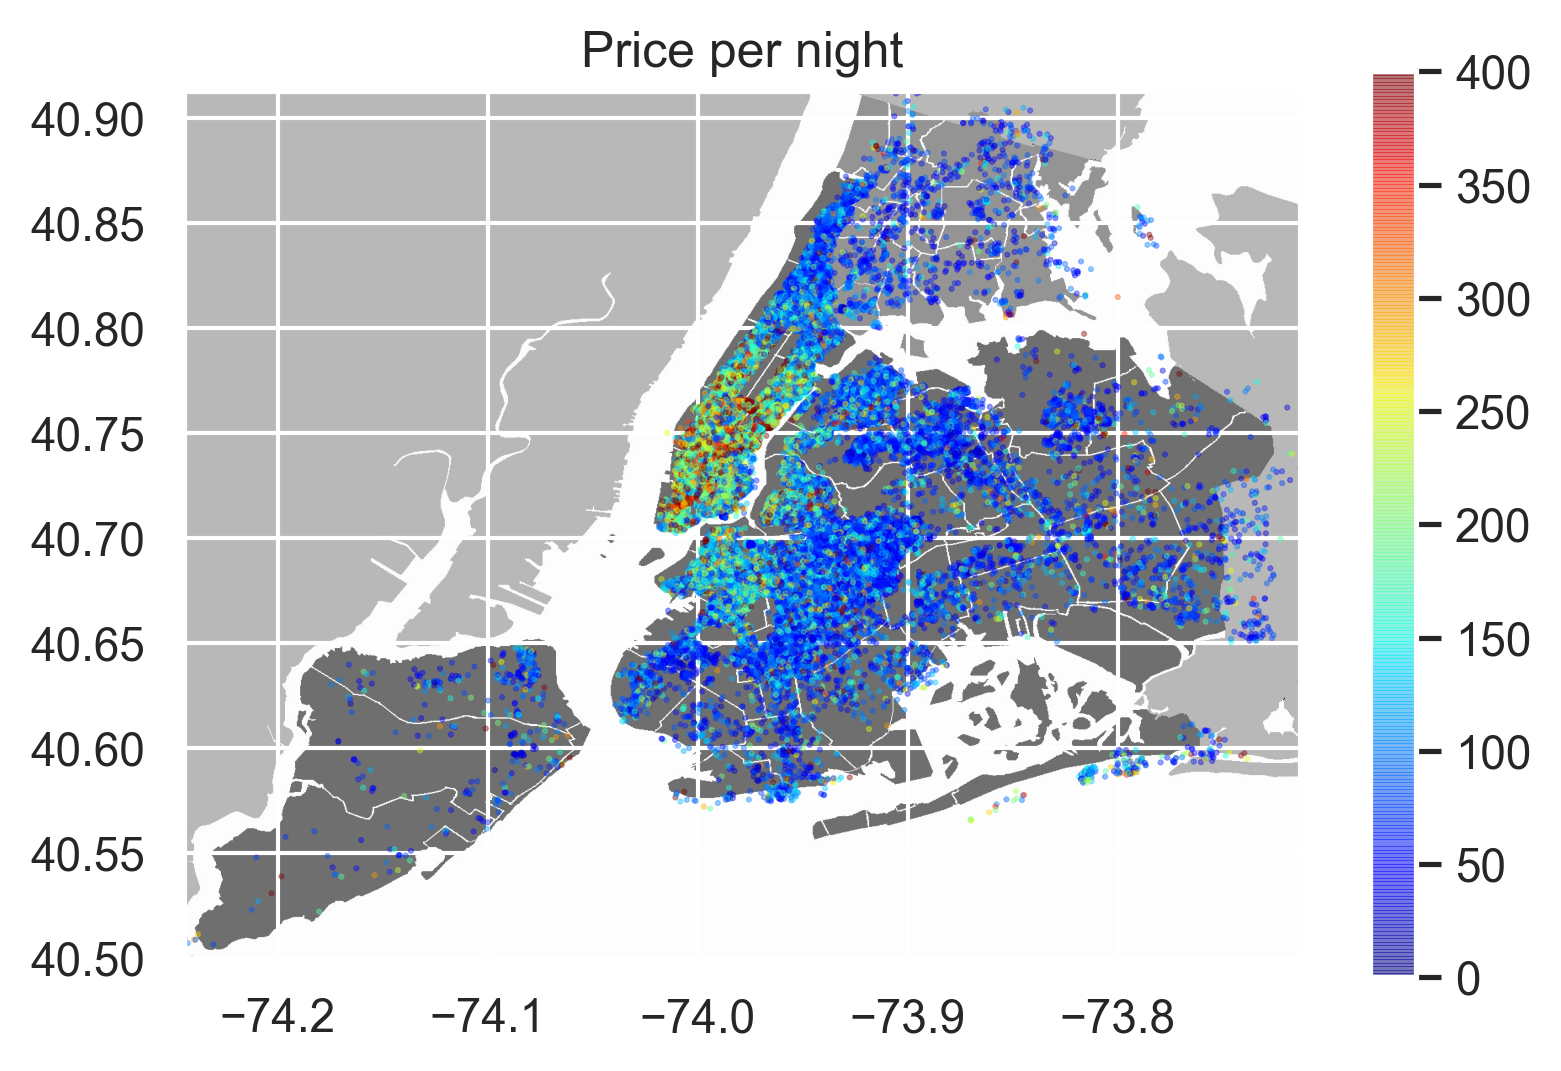

In [6]:
fig = plt.figure(dpi=150)
img = Image.open("archive/New_York_City_.png")
long = data["longitude"]
lat = data["latitude"]
plt.imshow(img, extent=(long.min(),long.max(),lat.min(),lat.max()))
plt.scatter(long, lat, s=0.2, c=data["price"], cmap=plt.get_cmap("jet"), alpha=0.5, vmin=0, vmax=400)
plt.colorbar()
plt.title("Price per night")
plt.show()

We see that the price is indeed correlated with the location, namely apartments in Manhattan and to some degree in Brooklyn are much more expensive than apartments in Queens, Bronx and Staten Island. Not only this, we also see that apartments on Staten Island are very sparse and it wouldn't be suprising if these apartments had little impact on our prediction / model later on.

Now to explore some more general correaltions within our data set, we plot the correlation matrix.

<AxesSubplot:>

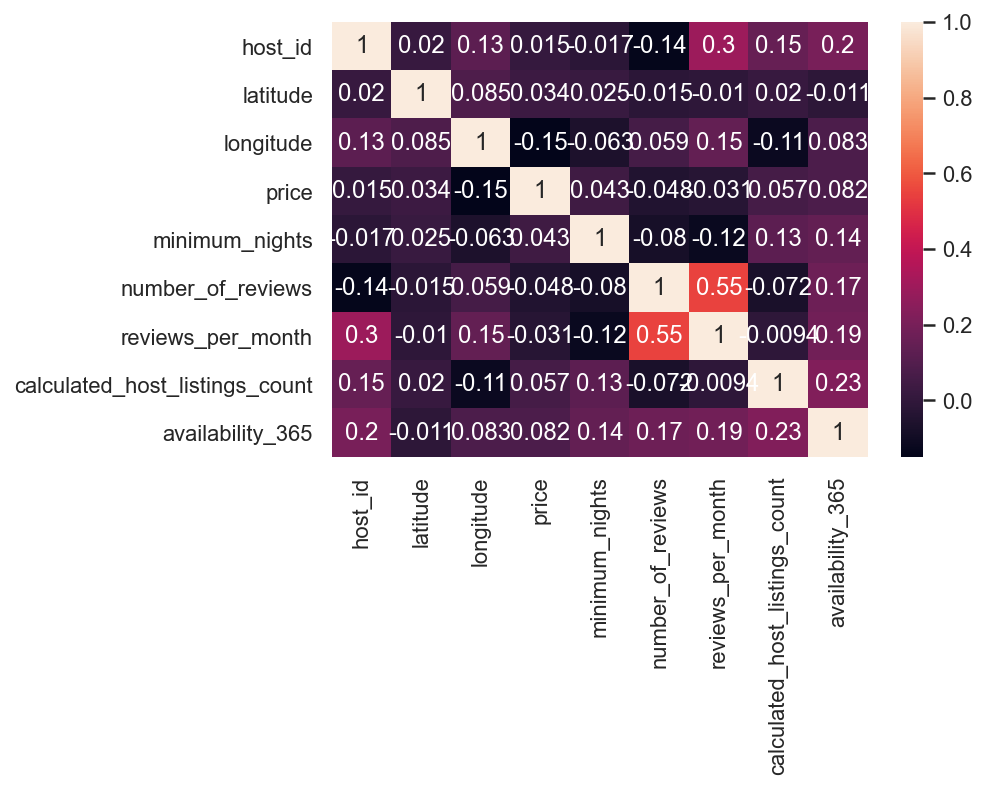

In [7]:
sns.set_theme()
sns.heatmap(data.corr(method="pearson"), annot=True)

<AxesSubplot:>

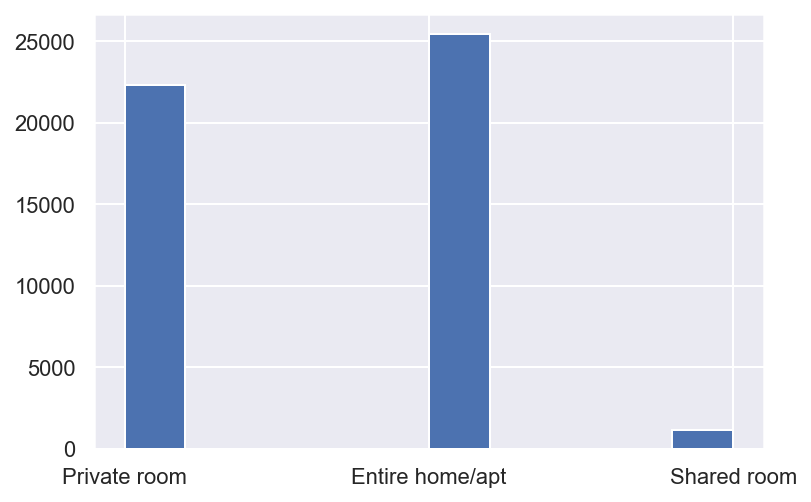

In [8]:
data["room_type"].hist()

<AxesSubplot:>

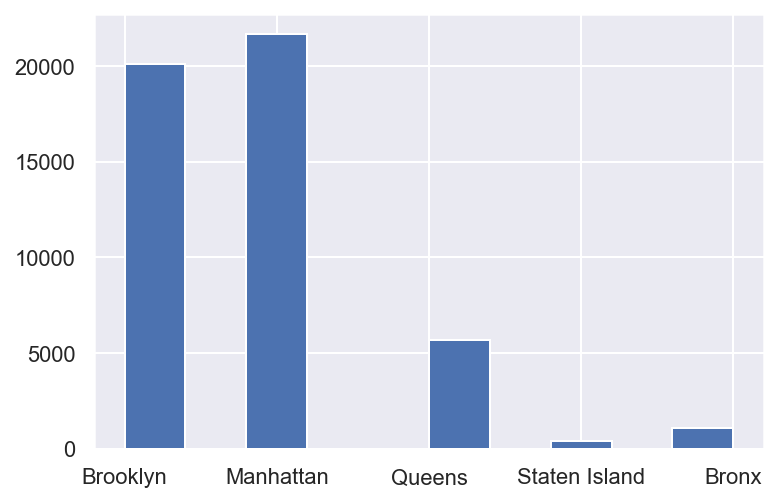

In [9]:
data["neighbourhood_group"].hist()

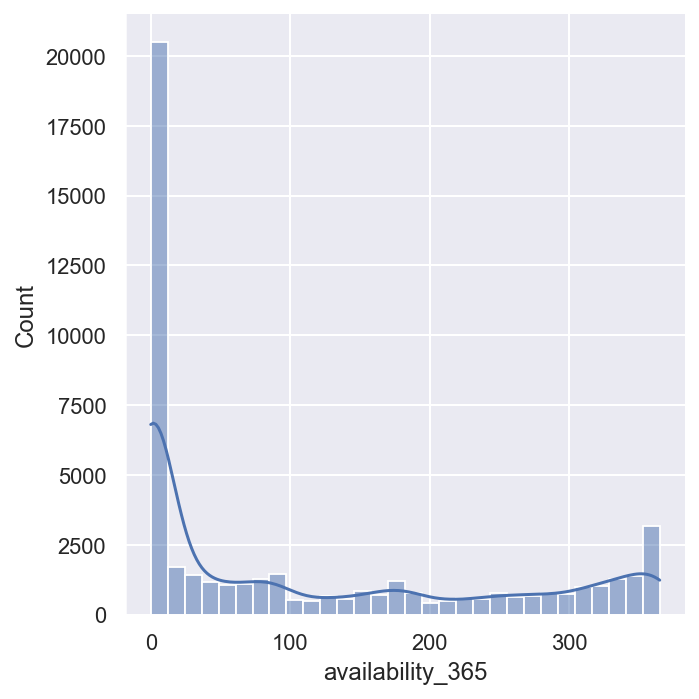

In [10]:
sns.displot(data["availability_365"], kde=True)

<AxesSubplot:xlabel='neighbourhood_group', ylabel='price'>

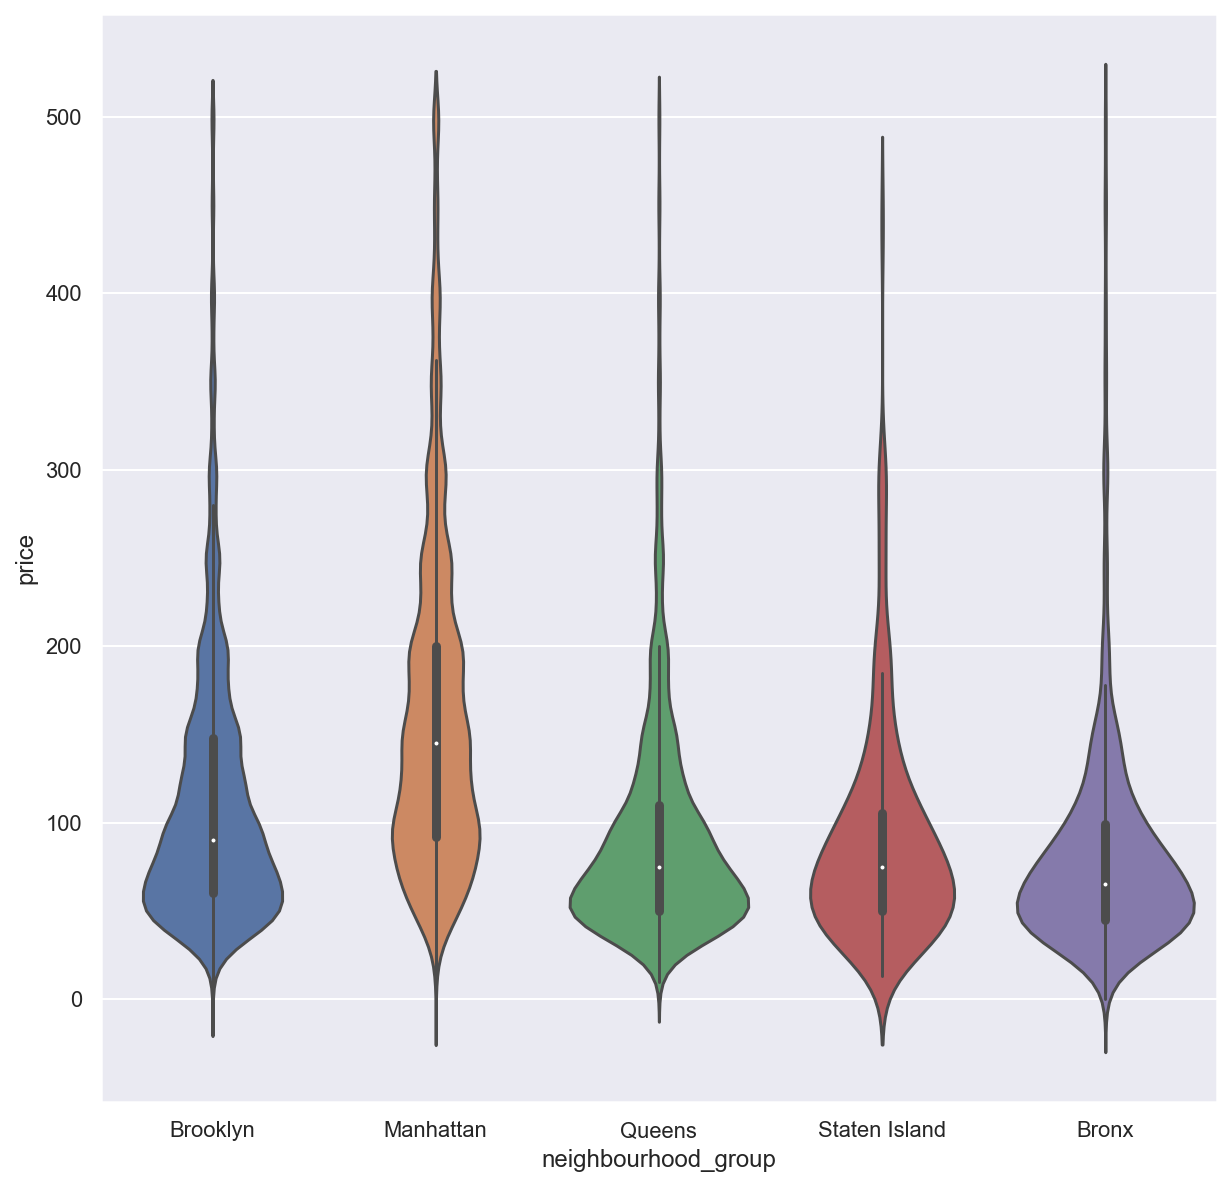

In [11]:
plt.figure(figsize=(10,10))
sub_500 = data[data.price <= 500]
sns.violinplot(data=sub_500, x=sub_500.neighbourhood_group, y=sub_500.price)

# Building the model

Now it's time that we build our model. Given that the covariance matrix of our data showed some very weak correlations between the features, we assume a linear model here. But first we need to adjust our `DataFrame` for our model. For partly ethical reasons we will start by dropping the `host_name`. Furthermore we will cut the price at 300$ because there are a few outlier with prices that are much larger than the average but very few in number.

In [12]:
data.drop(["name"], axis=1, inplace=True)
data = data[data.price < 300]

Next we take care of the missing values in the `reviews_per_month` column by filling them with zeros.

In [13]:
data.reviews_per_month.fillna(0, inplace=True)

Now we need to take care of the categorical variables `neighbourhood` and `neighbourhood_group`. We will drop the former to avoid the curse of dimensionality since there are a larger number of different neighbourhoods in our data set. The latter we will encode using a one-hot encoding scheme - same with `room_type`. Finally we will drop the `Staten Island` categorical value as the number of appartments in Staten Island is small compared to the rest.

In [14]:
dataset_onehot1 = pd.get_dummies(data, columns=['neighbourhood_group',"room_type"], prefix = ['ng',"rt"],drop_first=True)
dataset_onehot1.drop(["neighbourhood", "ng_Staten Island", "host_name"], axis=1, inplace=True)
X = dataset_onehot1.drop("price", axis=1).copy()
y = dataset_onehot1.price.copy()

In [15]:
X.head()

,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,ng_Brooklyn,ng_Manhattan,ng_Queens,rt_Private room,rt_Shared room
0,2787,40.64749,-73.97237,1,9,0.21,6,365,1,0,0,1,0
1,2845,40.75362,-73.98377,1,45,0.38,2,355,0,1,0,0,0
2,4632,40.80902,-73.94190,3,0,0.00,1,365,0,1,0,1,0
3,4869,40.68514,-73.95976,1,270,4.64,1,194,1,0,0,0,0
4,7192,40.79851,-73.94399,10,9,0.10,1,0,0,1,0,0,0


Now we create a training and test set in an 80/20 ratio.

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Linear regression

In [17]:
model = sklearn.linear_model.LinearRegression()
model.fit(x_train, y_train)
model.score(x_train, y_train)

0.4959569037776568

Let's check the coefficients of our model to see which features are important and which we may be able to toss. 

In [18]:
coef_df = pd.DataFrame({"Variable" : x_test.columns, "Coefficient" : model.coef_})
coef_df.sort_values("Coefficient", ascending=False)

,Variable,Coefficient
9,ng_Manhattan,4.229825e+01
10,ng_Queens,2.253777e+01
8,ng_Brooklyn,1.712904e+01
6,calculated_host_listings_count,9.701196e-02
7,availability_365,5.001264e-02
0,host_id,8.560511e-09
4,number_of_reviews,-2.860652e-02
3,minimum_nights,-1.993273e-01
5,reviews_per_month,-5.325623e-01
1,latitude,-1.712460e+01


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


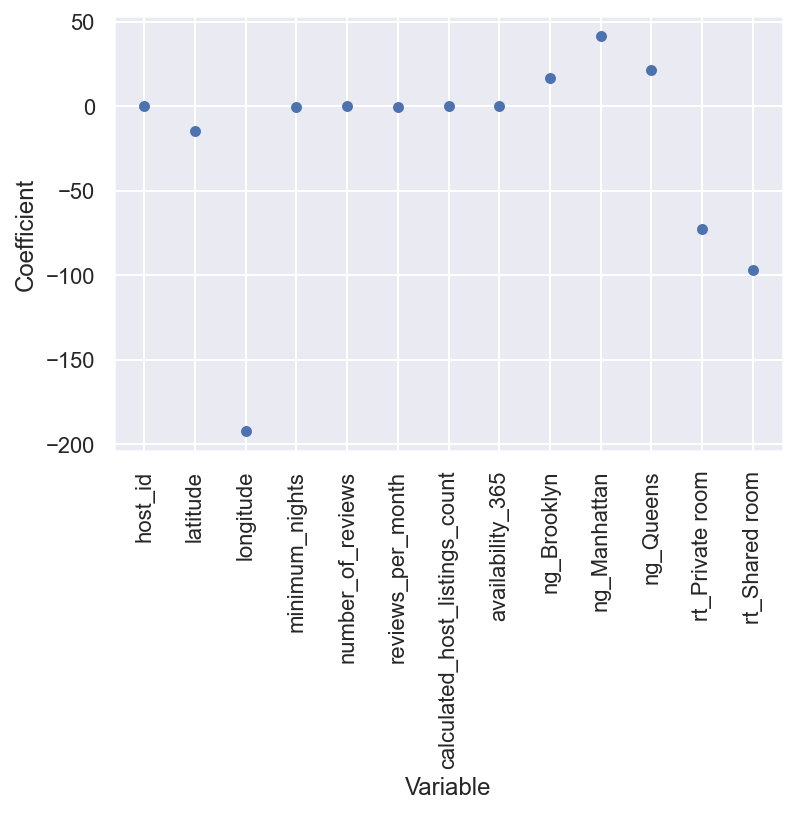

In [30]:
ax = coef_df.plot.scatter(x="Variable", y="Coefficient")
ax.tick_params(axis='x', rotation=90)

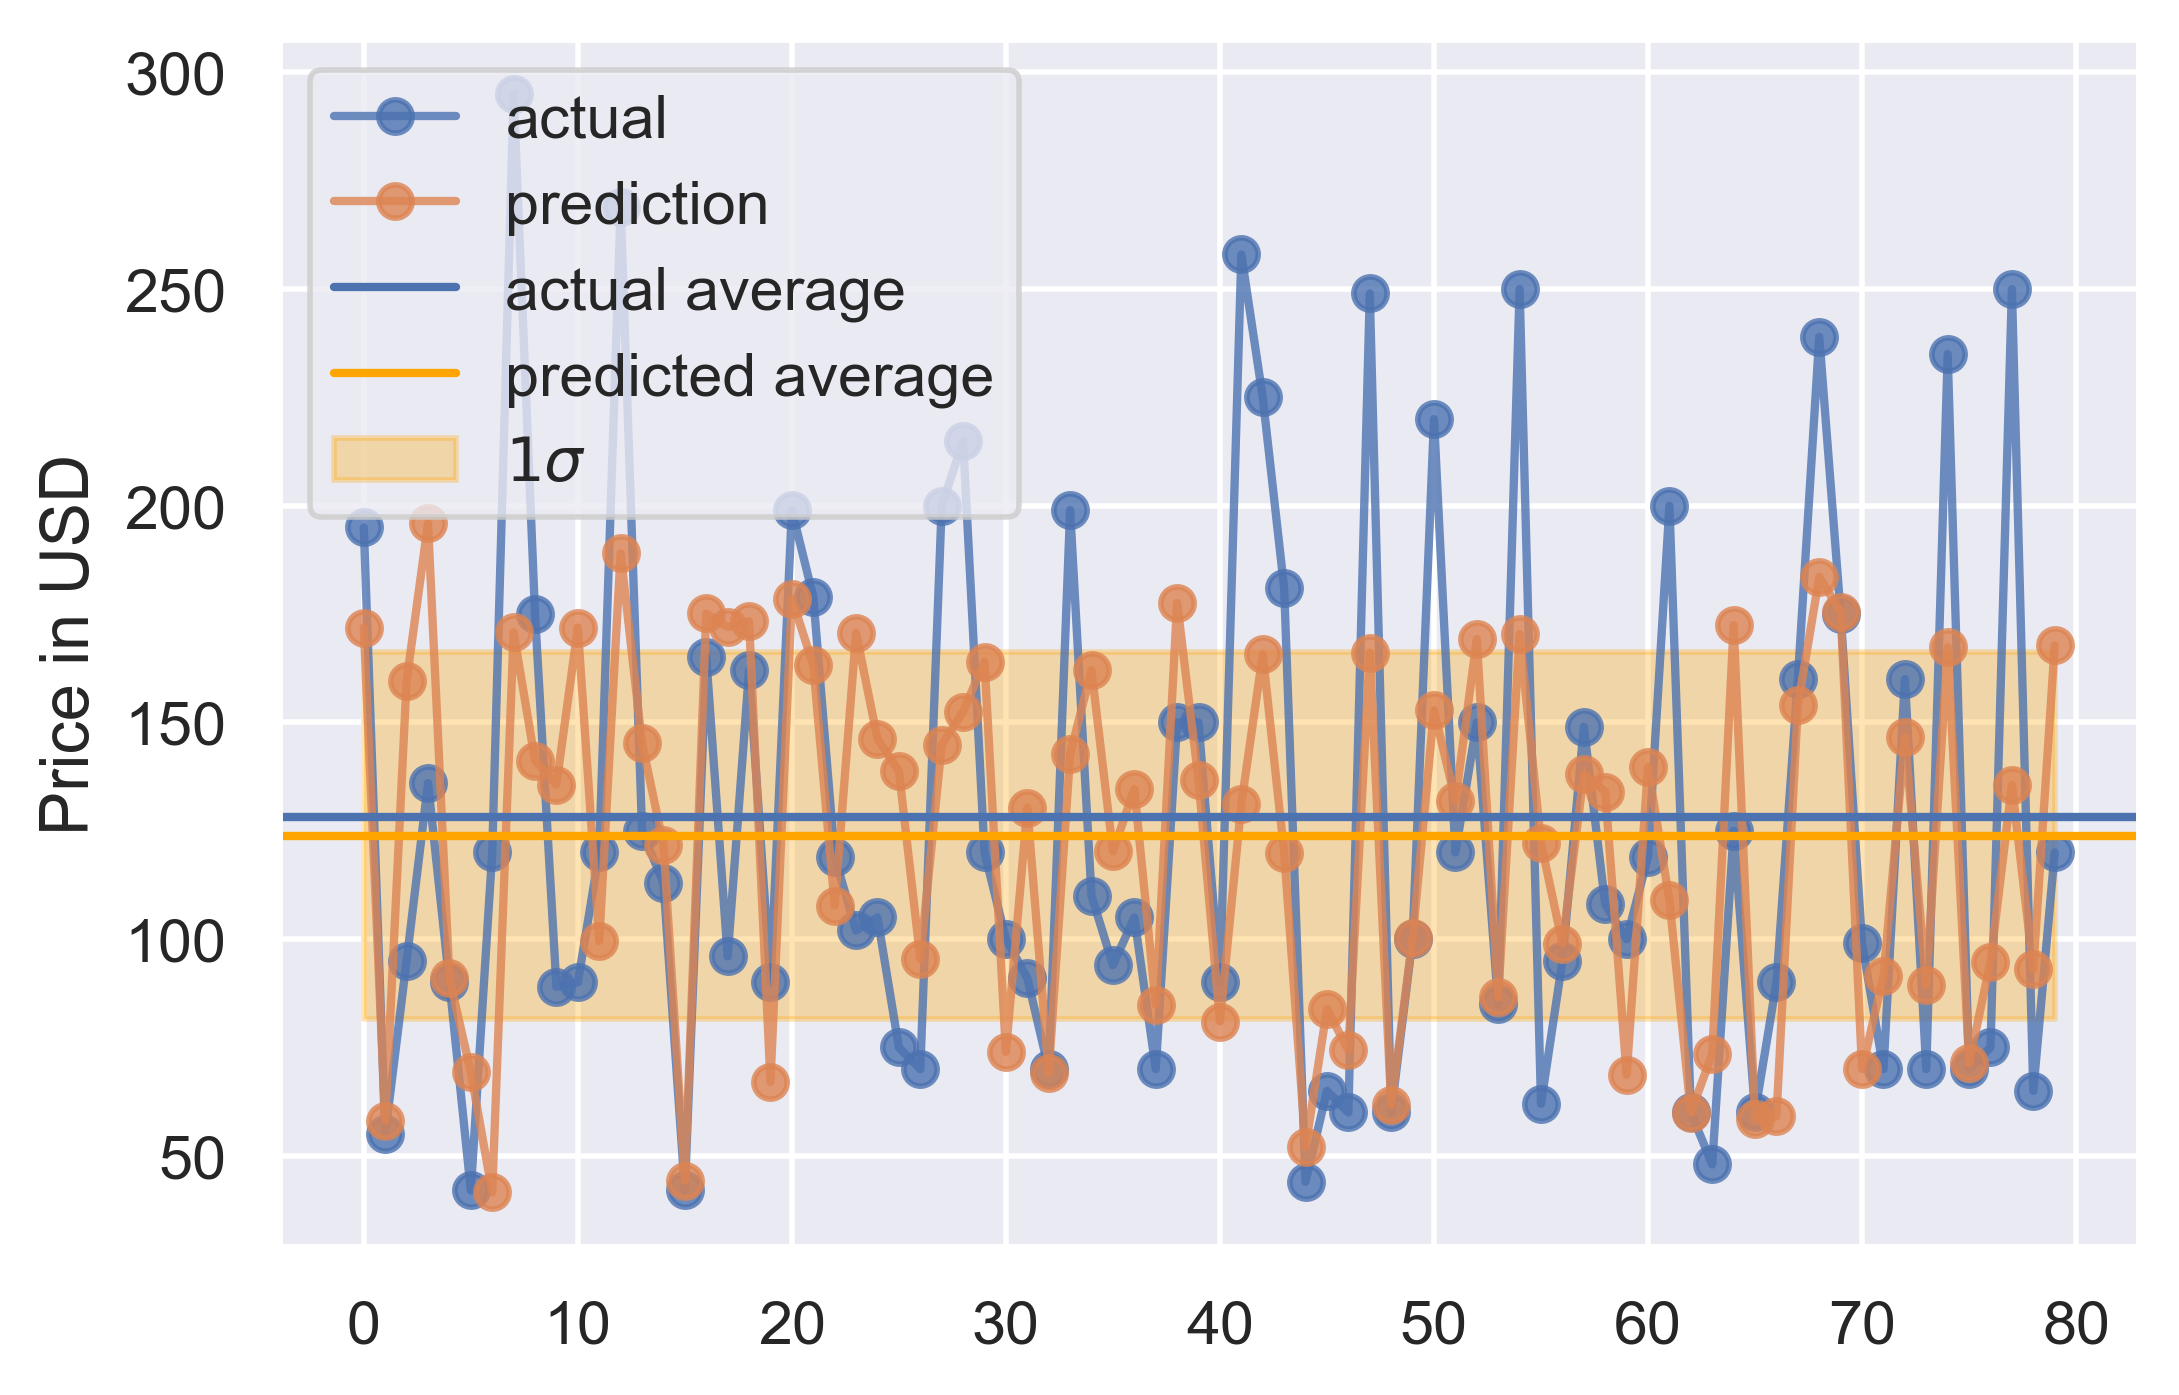

In [31]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.plot(range(80), y_test[:80], marker="o", alpha=.8, label="actual")
mu = y_test[:80].mean()
mu_pred = model.predict(x_test[:80]).mean()
std_pred = model.predict(x_test[:80]).std()
ax.plot(range(80), model.predict(x_test[:80]), marker="o", alpha=.8, label="prediction")
ax.axhline(mu, label="actual average")
ax.axhline(mu_pred, label="predicted average", c="orange")
ax.fill_between(range(80), mu_pred+std_pred, mu_pred-std_pred, alpha=.3, label="$1\sigma$", color="orange")
ax.set_ylabel("Price in USD")
ax.legend()

## LASSO regression

Let's see if we can improve our model's performance by adding a regulariser - i.e. using a Lasso model.

In [19]:
regL1 = sklearn.linear_model.Lasso(alpha=0.01)
regL1.fit(x_train, y_train)
regL1.score(x_train, y_train)

0.4959238232396411

In [20]:
coef_df = pd.DataFrame({"Variable" : x_test.columns, "Coefficient" : regL1.coef_})
coef_df.sort_values("Coefficient", ascending=False)

,Variable,Coefficient
9,ng_Manhattan,4.160008e+01
10,ng_Queens,2.116866e+01
8,ng_Brooklyn,1.649823e+01
6,calculated_host_listings_count,9.841871e-02
7,availability_365,4.981041e-02
0,host_id,8.120638e-09
4,number_of_reviews,-2.867265e-02
3,minimum_nights,-1.987009e-01
5,reviews_per_month,-5.347588e-01
1,latitude,-1.445239e+01


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


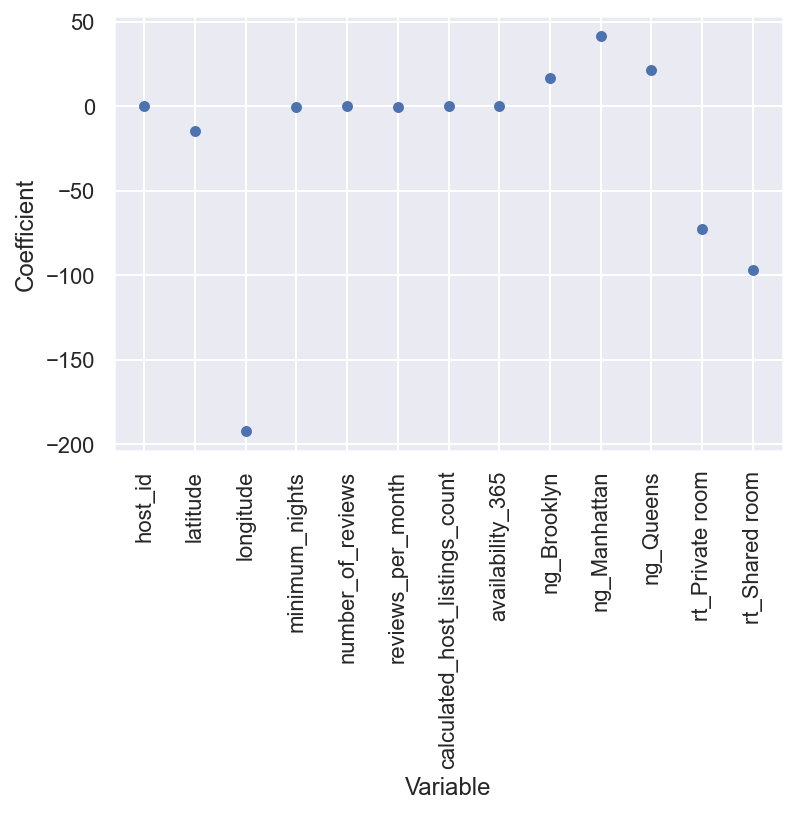

In [29]:
ax = coef_df.plot.scatter(x="Variable", y="Coefficient")
ax.tick_params(axis='x', rotation=90)

Let's see how our model performs

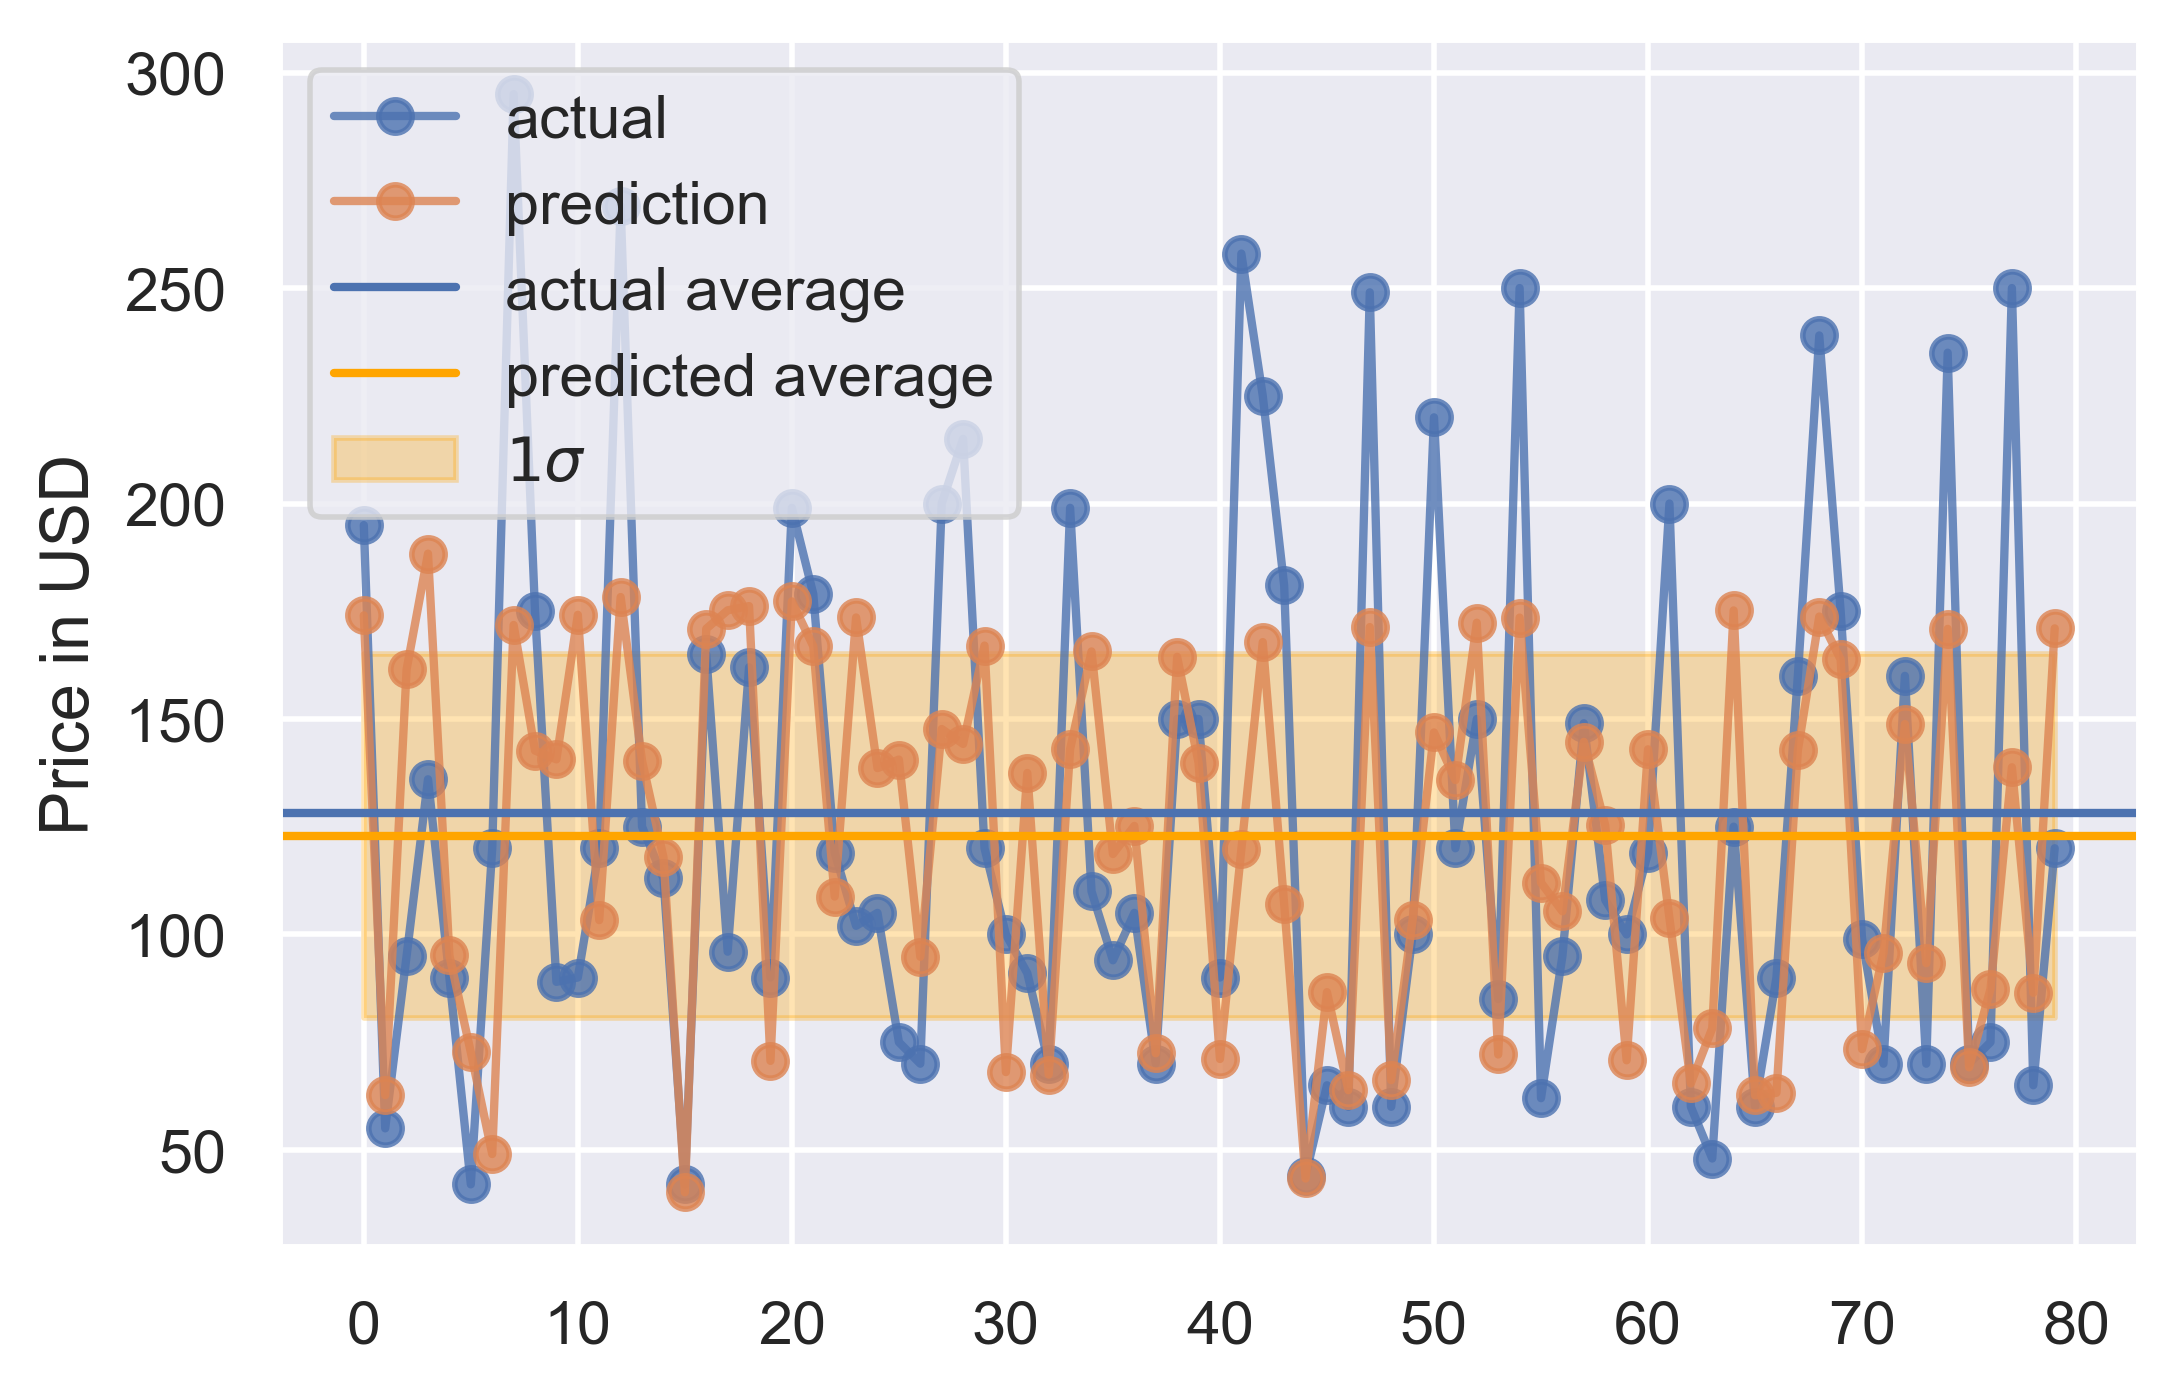

In [299]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
ax.plot(range(80), y_test[:80], marker="o", alpha=.8, label="actual")
mu = y_test[:80].mean()
mu_pred = regL1.predict(x_test[:80]).mean()
std_pred = regL1.predict(x_test[:80]).std()
ax.plot(range(80), regL1.predict(x_test[:80]), marker="o", alpha=.8, label="prediction")
ax.axhline(mu, label="actual average")
ax.axhline(mu_pred, label="predicted average", c="orange")
ax.fill_between(range(80), mu_pred+std_pred, mu_pred-std_pred, alpha=.3, label="$1\sigma$", color="orange")
ax.set_ylabel("Price in USD")
ax.legend()